In [1]:
import fm2p

Loading DLC 2.3.7...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


c:\Users\dmartins\anaconda3\envs\fm1\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
eye_dlc_h5 = r'K:\Mini2P\250218_DMM_DMM038_pillar\250218_DMM_DMM038_rec\250218_DMM_DMM038_rec_01_eyecam_deinterDLC_resnet50_freely_moving_eyecams_02Feb12shuffle1_100000.h5'
eye_TS_csv = r'K:\Mini2P\250218_DMM_DMM038_pillar\250218_DMM_DMM038_rec\250218_DMM_DMM038_rec_01_eyecam.csv'
eye_TTLV_csv = r'K:\Mini2P\250218_DMM_DMM038_pillar\250218_DMM_DMM038_rec\250218_DMM_DMM038_rec_01_logTTL.csv'
eye_TTLTS_csv = r'K:\Mini2P\250218_DMM_DMM038_pillar\250218_DMM_DMM038_rec\250218_DMM_DMM038_rec_01_ttlTS.csv'

In [ ]:
# start time should be ~60 sec into the video

In [4]:
pts, _ = fm2p.open_dlc_h5(eye_dlc_h5)

In [5]:
num_frames = pts['t_x'].size
eyeT = fm2p.read_timestamp_file(eye_TS_csv, position_data_length=num_frames)

In [6]:
eyeT

array([41673.975731 , 41673.9905855, 41674.00544  , ..., 41934.254233 ,
       41934.278617 , 41934.29463  ])

In [7]:
ttlT_series = pd.read_csv(eye_TTLTS_csv, encoding='utf-8', engine='c', header=None).squeeze()
ttlT = fm2p.read_timestamp_series(ttlT_series)

In [8]:
ttlV = pd.read_csv(eye_TTLV_csv, encoding='utf-8', engine='c', header=None).squeeze().to_numpy()

In [9]:
print(len(ttlV), len(ttlT))

13646 13646


In [10]:
startInd = int(np.argwhere(ttlV>0)[0])
startInd

3242

In [11]:
endInd = int(np.argwhere(ttlV>0)[-1])
endInd

13342

In [12]:
reye_cam = fm2p.Eyecam('', '')
reye_cam.add_files(
    eye_dlc_h5=eye_dlc_h5,
    eye_avi='',
    eyeT=eye_TS_csv
)
eye_xyl, ellipse_dict = reye_cam.track_pupil()

100%|██████████| 15602/15602 [00:01<00:00, 9477.87it/s] 


LinAlg error count = 136
boolean index did not match indexed array along dimension 1; dimension is 15602 but corresponding boolean dimension is 157
Error in scale, center, and calibration figures. Skipping these for now


In [40]:
import imgtools

In [43]:
376963072/512/512

1438.0

In [59]:
twopT = np.arange(0, 1438/7.5, 1/7.49)

(-0.19840507273304467, 0.7551349440657498)

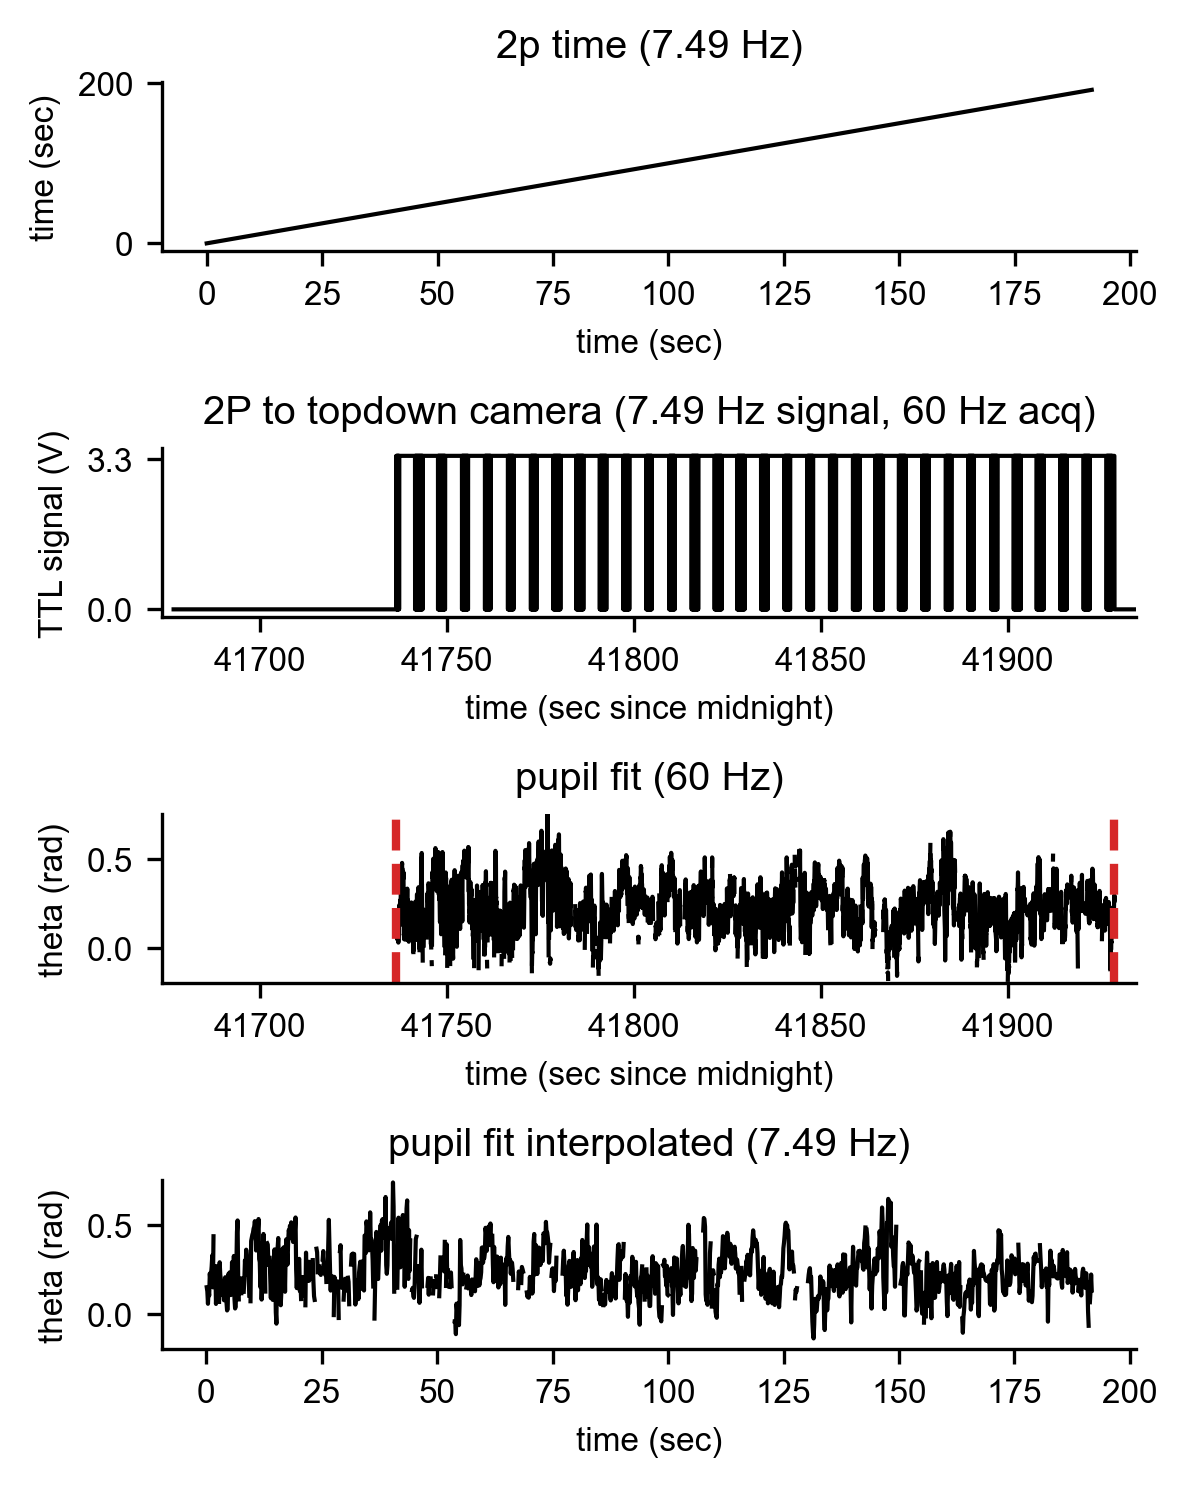

In [84]:
fig, [ax1,ax2,ax3,ax4] = plt.subplots(4,1, figsize=(4,5), dpi=300)

ax1.plot(twopT, twopT, 'k', lw=1)
ax1.set_xlabel('time (sec)')
ax1.set_ylabel('time (sec)')
ax1.set_title('2p time (7.49 Hz)')

ax2.plot(ttlT, ttlV*(3.3/1000), 'k-', lw=1)
ax2.set_ylabel('TTL signal (V)')
ax2.set_title('2P to topdown camera (7.49 Hz signal, 60 Hz acq)')
ax2.set_xlabel('time (sec since midnight)')
ax2.set_xlim([eyeT[0], eyeT[-1]])
ax2.set_yticks([0,3.3])

ax3.plot(eyeT, theta, 'k-', lw=1)
ax3.set_xlim([eyeT[0], eyeT[-1]])
ax3.set_xlabel('time (sec since midnight)')
ax3.vlines(eyeT[eyeStart], np.nanmin(theta), np.nanmax(theta), color='tab:red', ls='--', lw=2)
ax3.vlines(eyeT[eyeEnd], np.nanmin(theta), np.nanmax(theta), color='tab:red', ls='--', lw=2)
ax3.set_ylabel('theta (rad)')
ax3.set_ylim([np.nanmin(theta), np.nanmax(theta)])
ax3.set_title('pupil fit (60 Hz)')

ax4.set_ylabel('theta (rad)')
ax4.plot(twopT, theta_interp, 'k', lw=1)
ax4.set_title('pupil fit interpolated (7.49 Hz)')
ax4.set_xlabel('time (sec)')
ax4.set_ylim([np.nanmin(theta), np.nanmax(theta)])

fig.tight_layout()

In [74]:
theta_interp

array([nan, nan, nan, ..., nan, nan, nan])

In [32]:
theta = ellipse_dict['theta']

In [33]:
firstTheta = int(np.argwhere(~np.isnan(theta))[0])
lastTheta = int(np.argwhere(~np.isnan(theta))[-1])
print(firstTheta, lastTheta)

3747 15258


In [34]:
print('Theta: ', eyeT[firstTheta], ' to ', eyeT[lastTheta])
print('TTL: ', ttlT[startInd], ' to ', ttlT[endInd])

Theta:  41736.493222  to  41928.565158
TTL:  41736.462144  to  41928.514598


In [53]:
apply_t0 = ttlT[startInd]
apply_tEnd = ttlT[endInd]

In [54]:
def find_closest_timestamp(arr, t):

    ind = np.argmin(np.abs(arr - t))
    approx_t = arr[ind]

    return ind, approx_t

In [55]:
eyeStart, _ = find_closest_timestamp(eyeT, apply_t0)
eyeEnd, _ = find_closest_timestamp(eyeT, apply_tEnd)

In [63]:
eyeStart, eyeEnd

(3745, 15255)

In [75]:
theta_interp = fm2p.interpT(theta[eyeStart:eyeEnd], eyeT[eyeStart:eyeEnd]-eyeT[eyeStart], twopT)